<h2> HDB Price Prediction ML Model </h2>

<p> I found a dataset on HDB resale prices on the government's website, data.gov.sg. I wanted to create a regression model to predict the resale price of an apartment based on its key features, such as square footage, neighbourhood, etc. In this project, I experimented with a few Shallow Learning algorithms such as Linear Regression, Decision Trees and K-Nearest Neighbours</p>

In [2]:
#starting by importing libraries and the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_1990_to_1999 = pd.read_csv("./resale-flat-prices/resale-flat-prices-based-on-approval-date-1990-1999.csv")
data_2000_to_2012 = pd.read_csv("./resale-flat-prices/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
data_2012_to_2014 = pd.read_csv("./resale-flat-prices/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
data_2015_to_2016 = pd.read_csv("./resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
data_2017_to_2023 = pd.read_csv("./resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")
df = pd.concat([data_1990_to_1999, data_2000_to_2012, data_2012_to_2014, data_2015_to_2016, data_2017_to_2023], ignore_index = True)
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
898997,2023-04,YISHUN,EXECUTIVE,604,YISHUN ST 61,04 TO 06,164.0,Apartment,1992,935000.0,68 years 02 months
898998,2023-01,YISHUN,EXECUTIVE,724,YISHUN ST 71,10 TO 12,146.0,Maisonette,1986,780000.0,62 years 06 months
898999,2023-04,YISHUN,EXECUTIVE,723,YISHUN ST 71,10 TO 12,142.0,Apartment,1986,780000.0,62 years 02 months
899000,2023-04,YISHUN,EXECUTIVE,828,YISHUN ST 81,10 TO 12,142.0,Apartment,1988,865000.0,63 years 10 months


In [4]:
df.isna().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

<h3> Data Preprocessing and Feature Extraction </h3>


Firstly, I changed the string featueres to numerical values to be better understood by the model, by using techniques such as one-hot encoding. I also calculated remaining_lease_years manually to account for the missing values.

In [5]:
def extract_year_of_sale(string):
    years = string.split("-")[0]
    return int(years)

def calculate_remaining_lease_years(row):
    remaining_lease = row['lease_commence_date'] + 99 - row['year_of_sale']
    return remaining_lease

def calculate_average_story(string):
    array = string.split(" TO ")
    return (int(array[0]) + int(array[1])) / 2
    
    
df['year_of_sale'] = df['month'].apply(extract_year_of_sale)
df['remaining_lease_years'] = df.apply(calculate_remaining_lease_years, axis = 1)
df['average_storey'] = df['storey_range'].apply(calculate_average_story)

df['flat_type'] = df['flat_type'].str.lower()
df['flat_type'] = df['flat_type'].str.replace(' ', '-')

dummy_df_flattype = pd.get_dummies(df['flat_type'], prefix='type', drop_first = True)
dummy_df_town = pd.get_dummies(df['town'], prefix='town', drop_first = True)

df = pd.concat([df, dummy_df_flattype, dummy_df_town], axis=1)
df = df.drop(['month', 'lease_commence_date', 'storey_range', 'street_name', 'block', 'town', 'remaining_lease', 'flat_model', 'flat_type'], axis = 1)
df

,floor_area_sqm,resale_price,year_of_sale,remaining_lease_years,average_storey,type_2-room,type_3-room,type_4-room,type_5-room,type_executive,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,31.0,9000.0,1990,86,11.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,31.0,6000.0,1990,86,5.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,31.0,8000.0,1990,86,11.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,31.0,6000.0,1990,86,8.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,73.0,47200.0,1990,85,5.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898997,164.0,935000.0,2023,68,5.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
898998,146.0,780000.0,2023,62,11.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
898999,142.0,780000.0,2023,62,11.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
899000,142.0,865000.0,2023,64,11.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


<p> From the graph below, it's clear that the year of sale is directly propotional to the remaining lease years. Hence, it would be redundant to include both features in the training data, and could lead to overfitting </p>

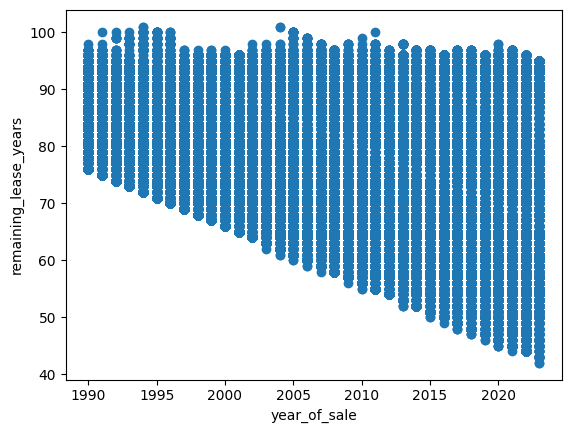

In [6]:
plt.scatter(df['year_of_sale'], df['remaining_lease_years'])
plt.xlabel('year_of_sale')
plt.ylabel('remaining_lease_years')
plt.show()

df = df.drop('remaining_lease_years', axis=1)

In [7]:
# Checking for any other strong correlation between features
corr_metrics = df.corr()

corr_metrics.style.background_gradient()

,floor_area_sqm,resale_price,year_of_sale,average_storey,type_2-room,type_3-room,type_4-room,type_5-room,type_executive,type_multi-generation,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_LIM CHU KANG,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
floor_area_sqm,1.000000,0.582647,0.068837,0.045152,-0.216606,-0.726415,0.025122,0.500497,0.564130,0.062254,-0.081469,0.059975,-0.023954,-0.104372,0.052817,0.025484,-0.077509,0.129638,-0.083236,-0.097874,0.039692,0.004831,0.048269,-0.079004,-0.008837,-0.037890,0.205447,0.020680,-0.161891,0.044297,0.051331,0.018259,0.100574,-0.092544,0.113440,-0.024398
resale_price,0.582647,1.000000,0.655738,0.242850,-0.113666,-0.485029,0.025751,0.342883,0.333820,0.031892,-0.071809,0.097404,-0.059281,0.036809,0.015215,0.042063,0.011828,0.036134,-0.036196,-0.047987,-0.001254,-0.035241,-0.041379,0.003761,-0.012844,0.013311,0.104375,0.140188,-0.022092,0.043301,0.131559,0.009888,0.032238,-0.015685,-0.011722,-0.083704
year_of_sale,0.068837,0.655738,1.000000,0.104004,-0.001738,-0.130452,0.054937,0.082178,0.008250,-0.008753,-0.058023,-0.023049,-0.038085,0.001472,0.043339,-0.005178,-0.003243,0.033876,-0.038291,-0.025127,-0.010745,-0.026189,0.006328,-0.002701,-0.010632,-0.022039,-0.005254,0.177493,-0.016694,0.087921,0.176282,-0.025395,-0.053700,-0.016680,0.049901,-0.040424
average_storey,0.045152,0.242850,0.104004,1.000000,-0.016738,-0.081198,-0.006046,0.128963,-0.035631,-0.003954,-0.005121,0.001987,-0.023896,0.067897,0.033364,-0.001901,0.088287,0.001120,0.008024,-0.019118,-0.033543,0.008425,-0.008874,0.044319,-0.007667,0.033607,-0.029397,0.055919,0.065965,0.020578,0.074765,-0.034359,-0.078536,0.039636,-0.041115,-0.067466
type_2-room,-0.216606,-0.113666,-0.001738,-0.016738,1.000000,-0.076768,-0.086967,-0.057531,-0.031892,-0.002726,0.003871,-0.017190,-0.024104,0.043195,-0.013283,-0.005837,0.076408,-0.019618,-0.016394,0.072782,-0.024406,-0.014824,-0.024710,0.024990,-0.000941,-0.009413,-0.018523,0.003110,0.128337,0.000120,-0.003718,-0.012814,-0.031925,0.022076,-0.024598,-0.025296
type_3-room,-0.726415,-0.485029,-0.130452,-0.081198,-0.076768,1.000000,-0.536987,-0.355229,-0.196922,-0.016832,0.082129,-0.060786,0.045650,0.058116,-0.062570,-0.014101,0.042678,-0.114900,0.101312,0.059365,-0.037892,0.028224,-0.030585,0.076228,0.007175,0.038801,-0.130254,-0.081065,0.119395,-0.078095,-0.114076,-0.024291,-0.049833,0.098136,-0.102797,-0.003754
type_4-room,0.025122,0.025751,0.054937,-0.006046,-0.086967,-0.536987,1.000000,-0.402422,-0.223083,-0.019068,-0.035572,0.034483,0.001203,-0.039645,0.032066,-0.001113,-0.015951,0.054387,-0.034674,-0.025498,0.038768,-0.033553,0.004802,-0.036723,-0.001687,-0.026851,0.005350,0.025426,-0.075951,0.019586,0.036634,0.025092,0.018772,-0.054261,0.045127,0.058313
type_5-room,0.500497,0.342883,0.082178,0.128963,-0.057531,-0.355229,-0.402422,1.000000,-0.147574,-0.012614,-0.031012,0.024691,-0.052989,-0.009274,0.026175,0.005408,-0.033827,0.051009,-0.049471,-0.040887,-0.011525,0.011017,0.028035,-0.026419,-0.004353,0.007962,0.053318,0.077342,-0.051977,0.051733,0.086543,-0.017581,0.026377,-0.031345,0.052377,-0.046419
type_executive,0.564130,0.333820,0.008250,-0.035631,-0.031892,-0.196922,-0.223083,-0.147574,1.000000,-0.006993,-0.031502,0.011726,0.010578,-0.055895,0.018269,0.021452,-0.025152,0.034386,-0.030937,-0.024039,0.025615,0.002162,0.014461,-0.035662,-0.002413,-0.026922,0.147333,-0.022801,-0.043585,0.023185,0.003945,0.030557,0.026466,-0.033279,0.030480,-0.020726
type_multi-generation,0.062254,0.031892,-0.008753,-0.003954,-0.002726,-0.016832,-0.019068,-0.012614,-0.006993,1.000000,-0.006840,0.025556,-0.005462,-0.004793,-0.004291,-0.001280,-0.002158,-0.005070,-0.004341,-0.004346,-0.005877,-0.004070,-0.006814,

<h3> Splitting data into training and testing sets </h3>

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('resale_price', axis=1)
y = df['resale_price']

X_values = X.values
y_values = y.values

X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, random_state = 10, test_size = 0.2)

<h3> Scaling features </h3>

<p> Some machine learning algorithms such as K-Nearest Neighbours are sensitive to the relative magnitude of features. This could lead to inaccuracy as a single feature might dominate the learning process. Hence I standaridized the continuous variables to have a mean of 0 and standard deviation of 1 </p>

In [9]:
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler


column_names = list(X.columns)
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_test_df = pd.DataFrame(X_test, columns=column_names)

# Initialize the scaler
scaler = StandardScaler()

continuous_features = ['floor_area_sqm', 'year_of_sale', 'average_storey'] 
# Fit the scaler on the continuous features from the training data
scaler.fit(X_train_df[continuous_features])

# Transform the continuous features of the training data
X_train_df[continuous_features] = scaler.transform(X_train_df[continuous_features])

# Transform the continuous features of the test data using the same scaler
X_test_df[continuous_features] = scaler.transform(X_test_df[continuous_features])

# Convert pandas DataFrames back to numpy arrays
X_train = X_train_df.values
X_test = X_test_df.values

<h3>Dimension Reduction </h3>

Currently the dataset has 37 features. With high dimensionality, the model might struggle to find meaningful patterns and would be inefficeint. Also training the model would take a long time and be computationally expensive. With PCA I can compresses the information from multiple correlated variables into a smaller set of uncorrelated variables

Text(0.5, 0, 'Principal Component #')

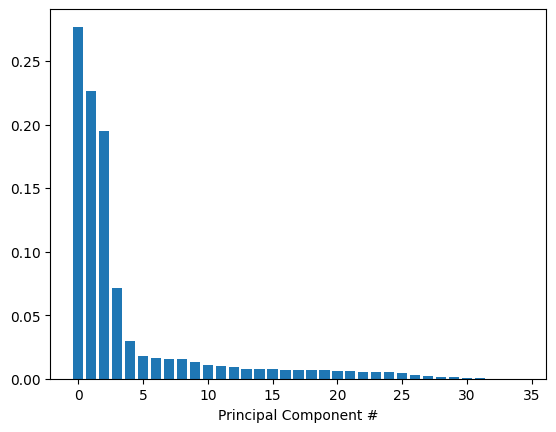

In [10]:
%matplotlib inline
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
exp_variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

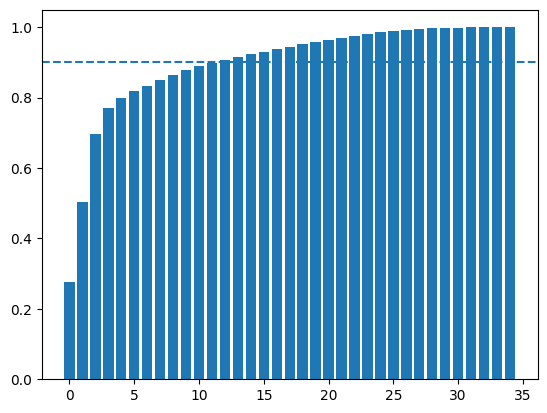

In [11]:
cum_exp_variance = np.cumsum(exp_variance)
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')

From the graph above, it appears that 90% of the variance can be obtained from 12 features alone.

In [88]:
pca = PCA(n_components = 12, random_state = 10)

pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

<h3> Training and testing the Regression Models </h3>

In [89]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

tree = DecisionTreeRegressor()
linreg = LinearRegression()
knn = KNeighborsRegressor()

tree.fit(pca_train, y_train)
linreg.fit(pca_train, y_train)
knn.fit(pca_train, y_train)

KNeighborsRegressor()

In [90]:
from sklearn.metrics import mean_squared_error

tree_y_predict = tree.predict(pca_test)
linreg_y_predict = linreg.predict(pca_test)
knn_y_predict = knn.predict(pca_test)

#calculate R^2
r2_tree = tree.score(pca_test, y_test)
r2_linreg = linreg.score(pca_test, y_test)
r2_knn = knn.score(pca_test, y_test)

#calculating mean_squared_error
mse_tree = mean_squared_error(y_test, tree_y_predict)
mse_linreg = mean_squared_error(y_test, linreg_y_predict)
mse_knn = mean_squared_error(y_test, knn_y_predict)

print("Linear Regression: MSE =", mse_linreg, ", R^2 =", r2_linreg)
print("Decision Tree: MSE =", mse_tree, ", R^2 =", r2_tree)
print("kNN: MSE =", mse_knn, ", R^2 =", r2_knn)

Linear Regression: MSE = 6337450396.063549 , R^2 = 0.7623050195731729
Decision Tree: MSE = 2856281255.8494987 , R^2 = 0.8928711587826601
kNN: MSE = 1796470766.4539275 , R^2 = 0.9326208400881736


<h3> Hyperparameter Tuning </h3> 
From the results above, it appears that KNN has the best performance, with the highest R^2 value and the lowest mean squared error.
However, this can hopefully be improved with hyperparameter tuning.

In [91]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


ridge_params = {
    'alpha': np.logspace(-5, 2, 100)
}

lasso_params = {
    'alpha': np.logspace(-5, 2, 100)
}

knn_params = {
    'n_neighbors': range(15, 41),
}

tree_params = {
    'max_depth': range(1, 31),
}

ridge = Ridge()
lasso = Lasso()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

ridge_search = GridSearchCV(ridge, ridge_params, cv=5, n_jobs = -1)
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, n_jobs = -1)
knn_search = GridSearchCV(knn, knn_params, cv=5, n_jobs = -1)
tree_search = GridSearchCV(tree, tree_params, cv=5, n_jobs = -1)

ridge_search.fit(pca_train, y_train)
lasso_search.fit(pca_train, y_train)
knn_search.fit(pca_train, y_train)
tree_search.fit(pca_train, y_train)

print(ridge_search.best_params_)
print(lasso_search.best_params_)
print(knn_search.best_params_)
print(tree_search.best_params_)

print(r2_score(y_test, ridge_search.predict(pca_test)))
print(r2_score(y_test, lasso_search.predict(pca_test)))
print(r2_score(y_test, knn_search.predict(pca_test)))
print(r2_score(y_test, tree_search.predict(pca_test)))

{'alpha': 4.534878508128582}
{'alpha': 0.06579332246575675}
{'n_neighbors': 15}
{'max_depth': 26}
0.7623049977312877
0.762305011616933
0.92522673182558
0.8917821278334435


<h3> Cross Validation </h3>

In [92]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

continuous_cols = [0, 1, 2]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols)  # Apply StandardScaler to continuous columns
    ],
    remainder="passthrough"  # Pass through the remaining columns as is (assumed to be categorical)
)


ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=4)),
    ("ridge", Ridge(**ridge_search.best_params_))
])

lasso_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=4)),
    ("lasso", Lasso(**lasso_search.best_params_))
])

knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor(**knn_search.best_params_))
])

tree_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=4)),
    ("tree", DecisionTreeRegressor(**tree_search.best_params_))
])


kf = KFold(10)

ridge_score = cross_val_score(ridge_pipe, X, y, cv=kf, scoring="r2")
lasso_score = cross_val_score(lasso_pipe, X, y, cv=kf, scoring="r2")
knn_score = cross_val_score(knn_pipe, X, y, cv=kf, scoring="r2")
tree_score = cross_val_score(tree_pipe, X, y, cv=kf, scoring="r2")

# Print the mean of each array of scores
print("Ridge mean:", np.mean(ridge_score))
print("Lasso mean:", np.mean(lasso_score))
print("KNN mean:", np.mean(knn_score))
print("Decision Tree mean:", np.mean(tree_score))

Ridge mean: 0.3862110410831754
Lasso mean: 0.386210729689232
KNN mean: 0.6058299629407669
Decision Tree mean: 0.13720107620398148


<h3> Conclusion </h3>

<p> Appears that KNN remains the superior algorithm for determining the best model for predicting HDB resale prices. However, it is not perfect as the R^2 score is only 0.61 after cross valiation.